In [95]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))\

import numpy as np
import pandas as pd
import GPy
try:
    from google.colab import files
    uploaded = files.upload()
except ImportError:
    pass
    
from matplotlib import pyplot as plt
    
%matplotlib inline

In [56]:
df=pd.read_csv('bitcoin_20172018april.csv')

In [57]:
df=df[:-2]
df["Dataindex"] = df.index                        ## Keep index, could be usefull
df.index=df.Date    
df.index=df.index.to_datetime()
df=df.drop(columns=['Date'])

/m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  after removing the cwd from sys.path.


In [60]:
df

,Close Price,Dataindex,Weekday
2017-04-10 00:00:00,1213.34,0,0
2017-04-11 00:00:00,1224.77,1,1
2017-04-12 00:00:00,1216.50,2,2
2017-04-13 00:00:00,1178.53,3,3
2017-04-14 00:00:00,1183.44,4,4
2017-04-15 00:00:00,1180.70,5,5
2017-04-16 00:00:00,1184.79,6,6
2017-04-17 00:00:00,1203.73,7,0
2017-04-18 00:00:00,1217.60,8,1
2017-04-19 00:00:00,1226.94,9,2


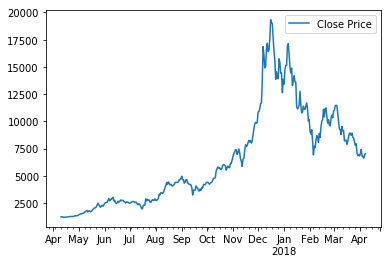

In [15]:
df.plot()

In [16]:
week_avg=df.groupby([df.index.weekday]).mean()

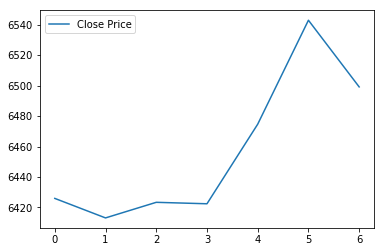

In [17]:
week_avg.plot()

In [18]:
df['Change']=df['Close Price'].pct_change()

In [19]:
week_avg_change=df['Change'].groupby([df.index.weekday]).mean()

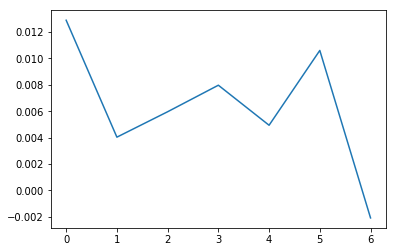

In [20]:
#0=monday
week_avg_change.plot()

In [21]:
week_avg_change

0    0.012890
1    0.004037
2    0.005961
3    0.007970
4    0.004939
5    0.010603
6   -0.002079
Name: Change, dtype: float64

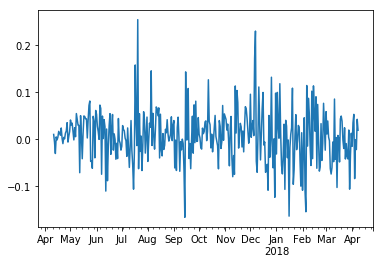

In [22]:
df['Change'].plot()

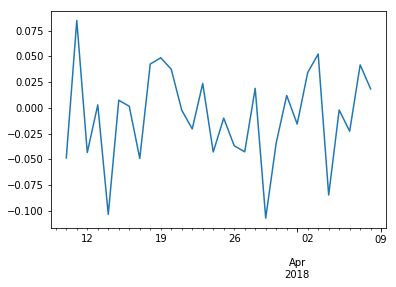

In [23]:
df['Change'][-30:].plot()

In [92]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"]).reshape(-1, 1)
X = np.array(df["Dataindex"]).reshape(-1, 1)



 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square
 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


GP_regression.,value,constraints,priors
sum.mul.rbf.variance,200072.61646316457,+ve,
sum.mul.rbf.lengthscale,10.754982503053165,+ve,
sum.mul.bias.variance,164.33947886078803,+ve,
sum.periodic_exponential.variance,249752.93752744162,+ve,
sum.periodic_exponential.lengthscale,3193965.5971837286,+ve,
sum.periodic_exponential.period,7.0,+ve fixed,
Gaussian_noise.variance,277209.0946487546,+ve,


(array([[-0.00051165]]), array([[33157038.66300759]]))


 /m/home/home2/27/holopaj7/unix/Envs/CS-Major/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


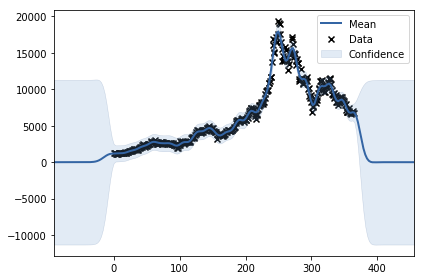

In [138]:
# http://www.cs.toronto.edu/~duvenaud/cookbook/                                                            Affects of addition and multiplication of kernels
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb              Lecture link: Kernel overview
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb                   Lecture link: GP Regression tutorial

RBF = GPy.kern.RBF(input_dim=1, variance=200000., lengthscale=20.)
RBF2 = GPy.kern.RBF(input_dim=1, variance=20000., lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1, variance=8000, lengthscale=0.5, period=7)
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1, variance=250000, lengthscale=20, period=7)
EXP_PER.period.fix()
LIN = GPy.kern.Linear(1, variances=55000)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)

RBF_PER = RBF*BIAS + EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3

m = GPy.models.GPRegression(X, Y, RBF_PER)
m.optimize()
display(m)

m.plot()

print(m.predict(np.array([450]).reshape(-1, 1)))

In [ ]:
## RANDOM SEARCH FOR THE OPTIMAL PARAMETERS?